# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [53]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ey,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[ALU],)
    )

                    

<Axes: xlabel='X', ylabel='Y'>

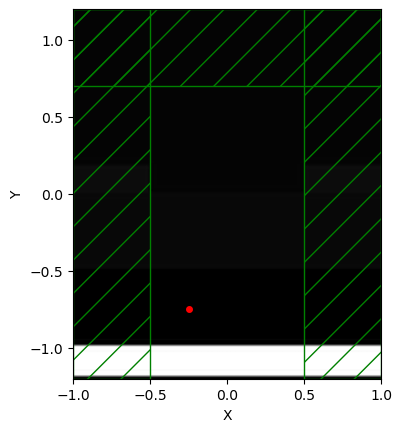

In [3]:
sim[0].plot2D()

<Axes: xlabel='X', ylabel='Y'>

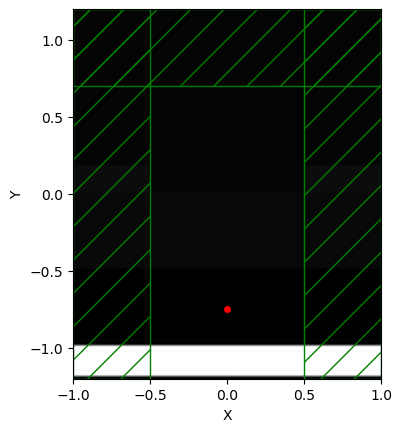

In [4]:
sim[1].plot2D()

<Axes: xlabel='X', ylabel='Y'>

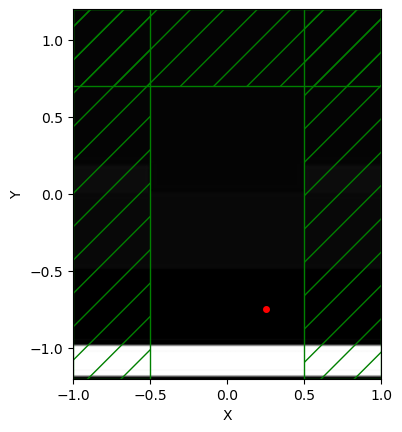

In [5]:
sim[2].plot2D()

In [ ]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)

FourierFields = []
for i in range(src_num):
    FourierFields.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Ex,yee_grid=True))
ob_list = []
for i in range(src_num):
    ob_list.append([FourierFields[i]])

def J(fields):
    return -npa.mean(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=ob_list[i],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

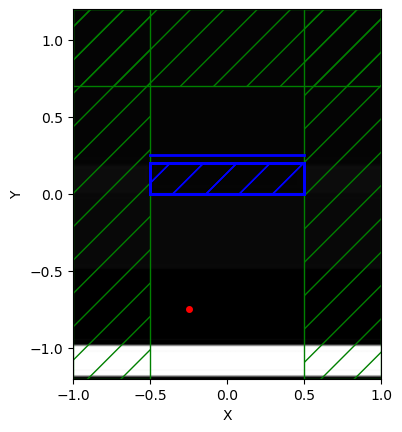

In [7]:
opt[0].plot2D(True)

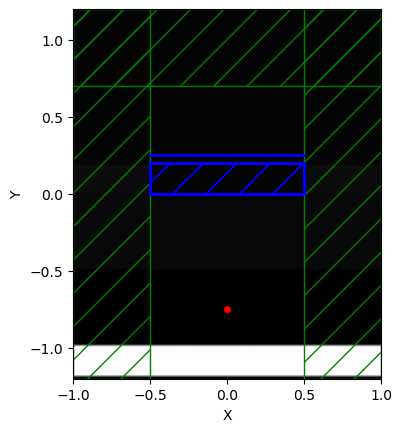

In [8]:
opt[1].plot2D(True)

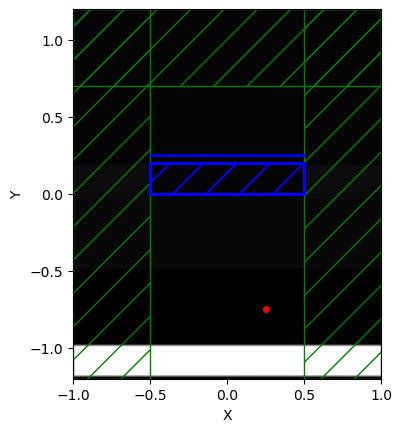

In [9]:
opt[2].plot2D(True)

In [10]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [11]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [12]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(x, gradient):
    t = x[0]
    v = x[1:]
    if gradient.size > 0:
        gradient[0] = 1
        gradient[1:] = 0
    return t

def c(result, x, gradient, beta):

    print("Current iteration: {}".format(cur_iter[0] + 1))

    global numevl
    t=x[0]
    v=x[1:]
    f0 = []
    dJ_du = []

    for i in range(src_num):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i.flatten())
        dJ_du.append(dJ_du_i)

    my_grad = np.zeros((Nx * Ny, src_num))

    for i in range(src_num):
        my_grad[:,i] = dJ_du[i]

    for k in range(src_num):
        my_grad[:,k] = tensor_jacobian_product(mapping,0)(
            v,
            eta_i,
            cur_beta,
            my_grad[:,k],
        )


    if gradient.size > 0:
        gradient[:, 0] = -1
        gradient[:, 1:] = my_grad.T

    result[:] = (np.real(f0) - t).reshape(-1)

    evaluation_history.append([np.max(np.real(f0[i])) for i in range(src_num)])
    
    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(src_num)]))


In [13]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

# insert dummy parameter bounds and variable
x = np.insert(x, 0, -1)  # our initial guess for the worst error
lb = np.insert(lb, 0, -np.inf) # lower bound for the error
ub = np.insert(ub, 0, 0) # upper bound for the error

# Optimization parameter
cur_beta = 4 # initial beta value
beta_scale = 1.5 # scaling factor for beta updates
num_betas = 9 # number of beta updates
tol_epi = np.array([1e-4] * 3) # tolerances for the epsilon constraints
update_factor = 12  # number of iterations between beta updates
ftol = 1e-5  # tolerance for the objective function

# Optimization
for iters in range(num_betas):
    print("current beta: ", cur_beta)
    solver = nlopt.opt(algorithm, n+1)
    solver.set_lower_bounds(lb) # lower bounds
    solver.set_upper_bounds(ub) # upper bounds
    solver.set_min_objective(f)
    solver.add_inequality_mconstraint(
        lambda rr, xx, gg: c(
            rr,
            xx,
            gg,
            cur_beta,
        ),
        tol_epi
    )
    solver.set_maxeval(update_factor) # Set the maximum number of function evaluations
        
    # solver.set_param("dual_ftol_rel", 1e-7)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale # Update the beta value for the next iteration


current beta:  4
Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.08712235], f0_1: [-0.09012057], f0_2: [-0.08712235]
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.08712446], f0_1: [-0.09012305], f0_2: [-0.08712446]
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.0871456], f0_1: [-0.09014777], f0_2: [-0.0871456]
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.08744374], f0_1: [-0.09049767], f0_2: [-0.08744374]
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.09063793], f0_1: [-0.09435991], f0_2: [-0.09063793]
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.10521994], f0_1: [-0.11420236], f0_2: [-0.10521994]
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.11144595], f0_1: [-0.12576525], f0_2: [-0.11144595]
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.11175985], f0_1: [-0.12760792], f0_2: [-0.11175985]
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.11190915], f0_1: [-0.12898777], f0_2: [-0.11190915]
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.11193129], f0_1: [-0.13014112], f0_2: [-0.11193129]
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.11183804], f0_1: [-0.13090838], f0_2: [-0.11183804]
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.11163596], f0_1: [-0.13162656], f0_2: [-0.11163596]
current beta:  6.0
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.0871456], f0_1: [-0.09014777], f0_2: [-0.0871456]
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.08714672], f0_1: [-0.09014796], f0_2: [-0.08714672]
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.08716106], f0_1: [-0.09015039], f0_2: [-0.08716106]
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.08736901], f0_1: [-0.09018576], f0_2: [-0.08736901]
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.08999032], f0_1: [-0.09065345], f0_2: [-0.08999032]
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.10449548], f0_1: [-0.10552248], f0_2: [-0.10449548]
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.11743896], f0_1: [-0.12007128], f0_2: [-0.11743896]
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12011551], f0_1: [-0.12100647], f0_2: [-0.12011551]
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12139346], f0_1: [-0.12176417], f0_2: [-0.12139346]
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12222109], f0_1: [-0.12241351], f0_2: [-0.12222109]
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12272749], f0_1: [-0.12282244], f0_2: [-0.12272749]
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12306518], f0_1: [-0.12310197], f0_2: [-0.12306518]
current beta:  9.0
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12306518], f0_1: [-0.12310197], f0_2: [-0.12306518]


Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.1230652], f0_1: [-0.12310186], f0_2: [-0.1230652]
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12306536], f0_1: [-0.12310075], f0_2: [-0.12306536]
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12306767], f0_1: [-0.12308495], f0_2: [-0.12306767]
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12308217], f0_1: [-0.12308327], f0_2: [-0.12308217]
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12315425], f0_1: [-0.12317608], f0_2: [-0.12315425]
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12321241], f0_1: [-0.12323713], f0_2: [-0.12321241]
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.1232498], f0_1: [-0.12326305], f0_2: [-0.1232498]
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12329748], f0_1: [-0.12331595], f0_2: [-0.12329748]
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12336284], f0_1: [-0.1233911], f0_2: [-0.12336284]
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12344716], f0_1: [-0.12345238], f0_2: [-0.12344716]
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12351662], f0_1: [-0.12349886], f0_2: [-0.12351662]
current beta:  13.5
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12351662], f0_1: [-0.12349886], f0_2: [-0.12351662]


Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12351604], f0_1: [-0.12350288], f0_2: [-0.12351604]
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12351485], f0_1: [-0.12351551], f0_2: [-0.12351485]


Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12351574], f0_1: [-0.12351582], f0_2: [-0.12351574]
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12351736], f0_1: [-0.12351745], f0_2: [-0.12351736]
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.1235263], f0_1: [-0.12352607], f0_2: [-0.1235263]
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12354704], f0_1: [-0.12354903], f0_2: [-0.12354704]
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12356521], f0_1: [-0.12357076], f0_2: [-0.12356521]
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12358524], f0_1: [-0.12359178], f0_2: [-0.12358524]
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12360682], f0_1: [-0.12361471], f0_2: [-0.12360682]
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.1236293], f0_1: [-0.12363419], f0_2: [-0.1236293]
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12364945], f0_1: [-0.12365532], f0_2: [-0.12364945]
current beta:  20.25
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12364945], f0_1: [-0.12365532], f0_2: [-0.12364945]
Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12364945], f0_1: [-0.1236553], f0_2: [-0.12364945]
Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12364946], f0_1: [-0.12365511], f0_2: [-0.12364946]
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12364957], f0_1: [-0.12365246], f0_2: [-0.12364957]


Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12364996], f0_1: [-0.12364993], f0_2: [-0.12364996]
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12365237], f0_1: [-0.12365276], f0_2: [-0.12365237]
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12365802], f0_1: [-0.1236607], f0_2: [-0.12365802]
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12366455], f0_1: [-0.12366793], f0_2: [-0.12366455]
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12367216], f0_1: [-0.12367635], f0_2: [-0.12367216]
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12367898], f0_1: [-0.12368197], f0_2: [-0.12367898]
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12368582], f0_1: [-0.12369028], f0_2: [-0.12368582]
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12369463], f0_1: [-0.12369941], f0_2: [-0.12369463]
current beta:  30.375
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12369463], f0_1: [-0.12369941], f0_2: [-0.12369463]


Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12369463], f0_1: [-0.1236994], f0_2: [-0.12369463]
Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12369464], f0_1: [-0.12369921], f0_2: [-0.12369464]
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12369473], f0_1: [-0.12369653], f0_2: [-0.12369473]
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.1236949], f0_1: [-0.12369485], f0_2: [-0.1236949]
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12369577], f0_1: [-0.12369576], f0_2: [-0.12369577]
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12369869], f0_1: [-0.12369948], f0_2: [-0.12369869]
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370086], f0_1: [-0.12370112], f0_2: [-0.12370086]
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370179], f0_1: [-0.12370181], f0_2: [-0.12370179]
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370273], f0_1: [-0.12370276], f0_2: [-0.12370273]
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370366], f0_1: [-0.12370354], f0_2: [-0.12370366]
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370419], f0_1: [-0.12370426], f0_2: [-0.12370419]
current beta:  45.5625
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370419], f0_1: [-0.12370426], f0_2: [-0.12370419]


Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370413], f0_1: [-0.12370497], f0_2: [-0.12370413]


Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370417], f0_1: [-0.12370478], f0_2: [-0.12370417]
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370419], f0_1: [-0.12370427], f0_2: [-0.12370419]
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370419], f0_1: [-0.12370415], f0_2: [-0.12370419]
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.1237042], f0_1: [-0.12370418], f0_2: [-0.1237042]
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370422], f0_1: [-0.12370419], f0_2: [-0.12370422]
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370423], f0_1: [-0.12370423], f0_2: [-0.12370423]
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370424], f0_1: [-0.12370426], f0_2: [-0.12370424]
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370425], f0_1: [-0.1237042], f0_2: [-0.12370425]
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370426], f0_1: [-0.12370424], f0_2: [-0.12370426]
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370428], f0_1: [-0.12370425], f0_2: [-0.12370428]
current beta:  68.34375
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370417], f0_1: [-0.12370478], f0_2: [-0.12370417]


Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370417], f0_1: [-0.1237047], f0_2: [-0.12370417]
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370418], f0_1: [-0.12370437], f0_2: [-0.12370418]


Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370419], f0_1: [-0.12370414], f0_2: [-0.12370419]
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370419], f0_1: [-0.12370417], f0_2: [-0.12370419]
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.1237042], f0_1: [-0.12370418], f0_2: [-0.1237042]
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370424], f0_1: [-0.12370423], f0_2: [-0.12370424]
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370428], f0_1: [-0.12370428], f0_2: [-0.12370428]
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370434], f0_1: [-0.12370432], f0_2: [-0.12370434]
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370443], f0_1: [-0.12370441], f0_2: [-0.12370443]
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370455], f0_1: [-0.12370451], f0_2: [-0.12370455]
Current iteration: 96
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370474], f0_1: [-0.12370467], f0_2: [-0.12370474]
current beta:  102.515625
Current iteration: 97
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370474], f0_1: [-0.12370467], f0_2: [-0.12370474]


Current iteration: 98
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370468], f0_1: [-0.12370542], f0_2: [-0.12370468]


Current iteration: 99
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370471], f0_1: [-0.12370533], f0_2: [-0.12370471]
Current iteration: 100
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370474], f0_1: [-0.12370478], f0_2: [-0.12370474]
Current iteration: 101
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370474], f0_1: [-0.12370471], f0_2: [-0.12370474]
Current iteration: 102
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370477], f0_1: [-0.12370469], f0_2: [-0.12370477]
Current iteration: 103
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370486], f0_1: [-0.12370481], f0_2: [-0.12370486]
Current iteration: 104
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370498], f0_1: [-0.12370492], f0_2: [-0.12370498]
Current iteration: 105
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370514], f0_1: [-0.12370508], f0_2: [-0.12370514]
Current iteration: 106
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370538], f0_1: [-0.12370529], f0_2: [-0.12370538]
Current iteration: 107
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370572], f0_1: [-0.12370558], f0_2: [-0.12370572]
Current iteration: 108
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [-0.08712234753707157, -0.09012056967309394, -0.08712234753707157]
Current f0 values: f0_0: [-0.12370623], f0_1: [-0.12370601], f0_2: [-0.12370623]


In [14]:
np.savetxt("lastdesign.txt", design_variables.weights)

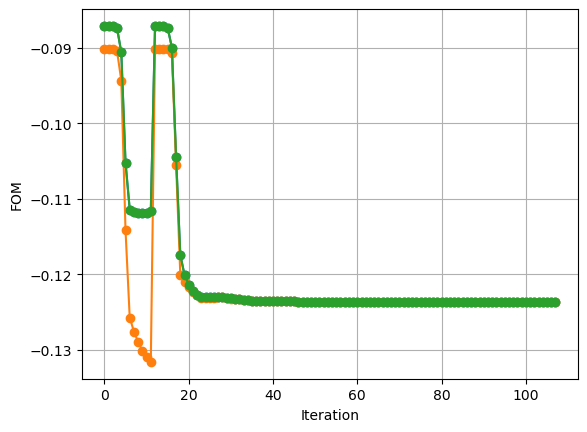

In [15]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

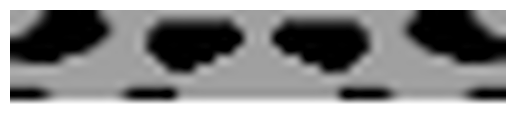

In [16]:
# opt[0].update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt[0].plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

FloatProgress(value=0.0, description='0% done ', max=200.0)

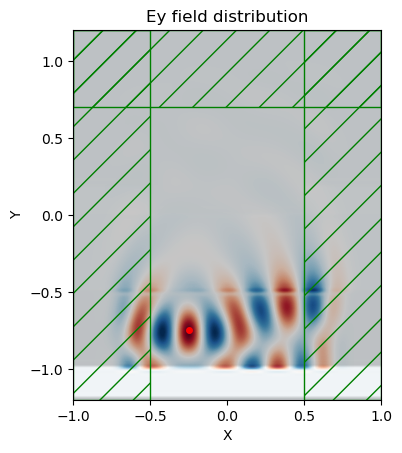

FloatProgress(value=0.0, description='0% done ', max=200.0)

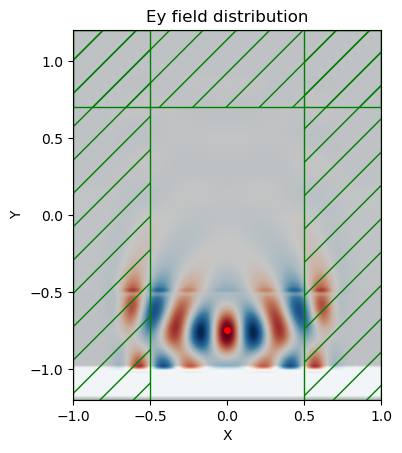

FloatProgress(value=0.0, description='0% done ', max=200.0)

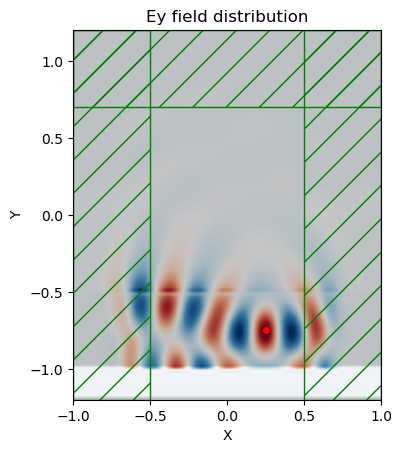

In [54]:
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ey,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )
ppopt =[]
for i in range(src_num):
    ppopt.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopt[i].run(until=200)
    ppopt[i].plot2D(fields=mp.Ey) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ey field distribution")
    plt.show()

In [55]:
flux_srcbox_top =[0]*src_num
flux_srcbox_bot =[0]*src_num
flux_srcbox_left =[0]*src_num
flux_srcbox_right =[0]*src_num

flux_glass =[0]*src_num
flux_wvgbox_right =[0]*src_num
flux_wvgbox_left =[0]*src_num

flux_total_srcbox =[0]*src_num
flux_total_glass =[0]*src_num
flux_waveguide =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

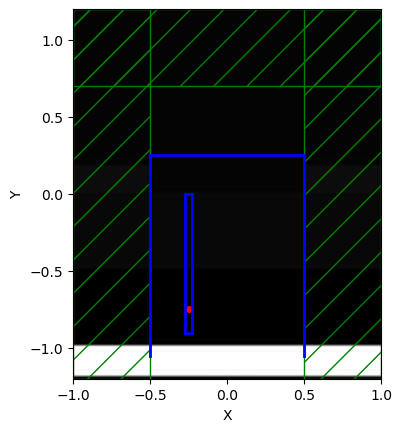

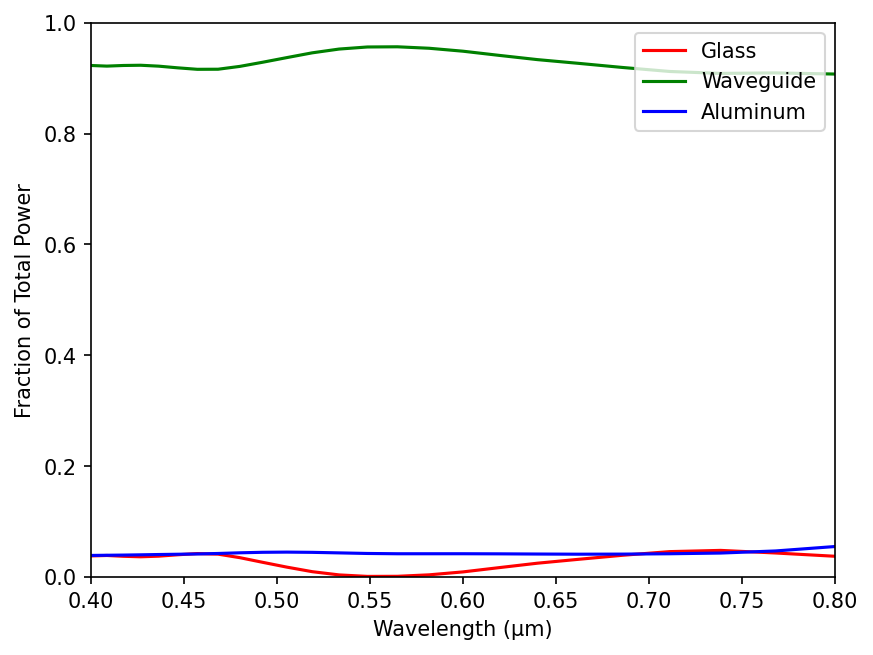

FloatProgress(value=0.0, description='0% done ')

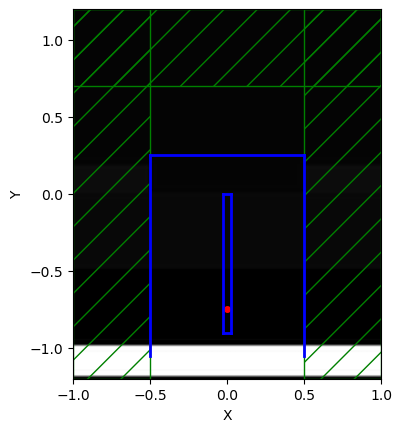

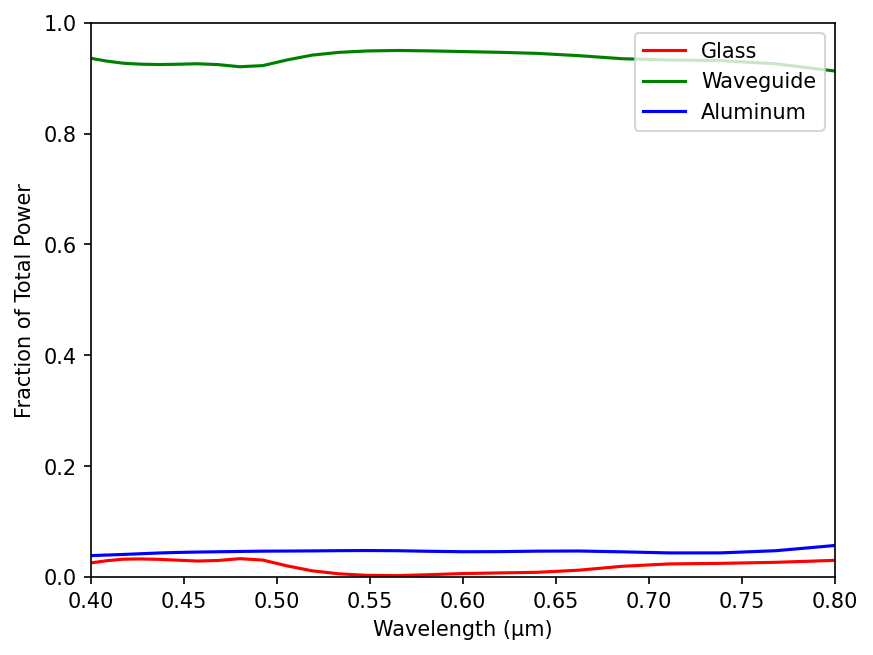

FloatProgress(value=0.0, description='0% done ')

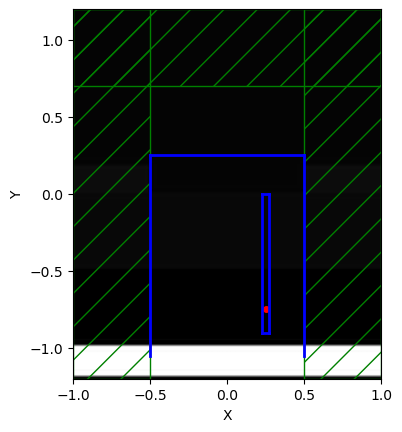

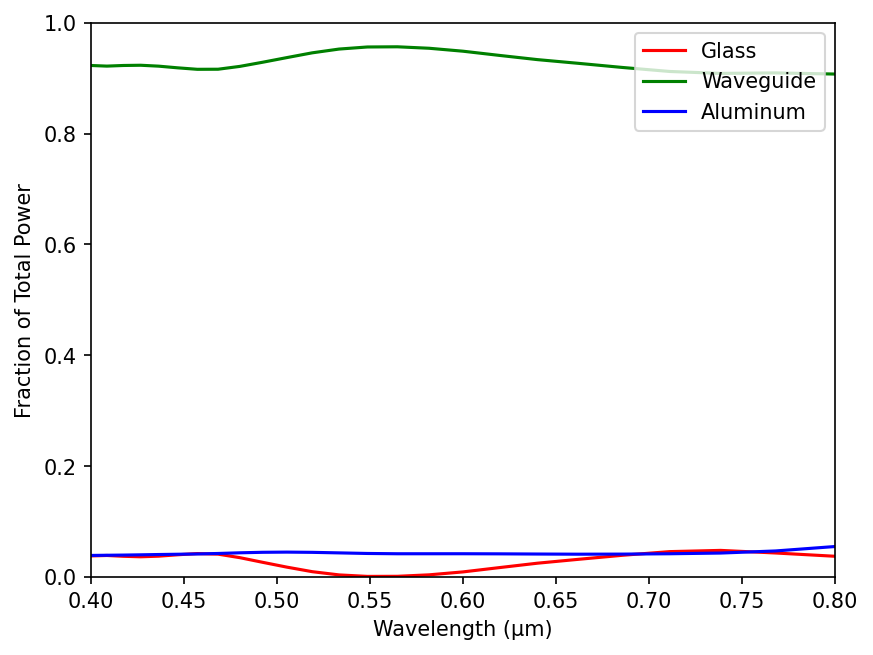

In [56]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox[i] = flux_srcbox_top[i] - flux_srcbox_bot[i] + flux_srcbox_right[i] - flux_srcbox_left[i]
    flux_total_glass[i] = flux_glass[i]
    flux_waveguide[i] = flux_wvgbox_right[i] - flux_wvgbox_left[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glass[i][d] / flux_total_srcbox[i][d])
        wg = np.append(wg, flux_waveguide[i][d] / flux_total_srcbox[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure




In [57]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

FloatProgress(value=0.0, description='0% done ', max=200.0)

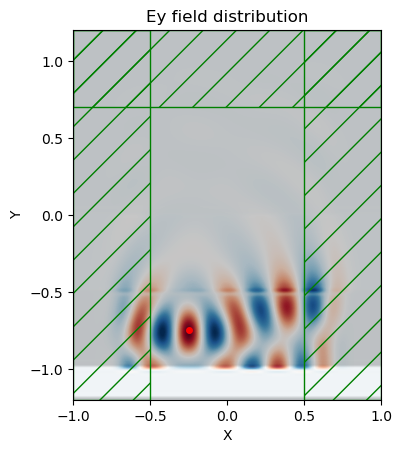

FloatProgress(value=0.0, description='0% done ', max=200.0)

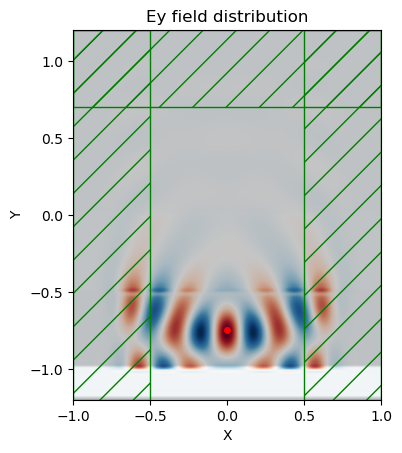

FloatProgress(value=0.0, description='0% done ', max=200.0)

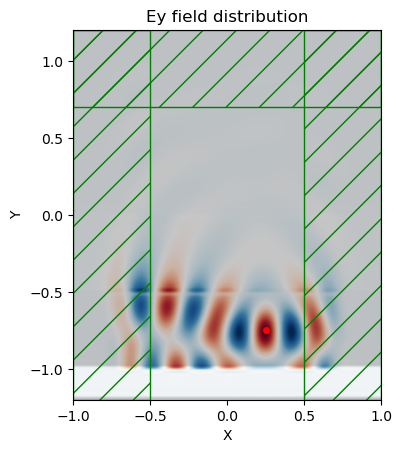

In [58]:
ppopto =[]
for i in range(src_num):
    ppopto.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometryo,
                      sources=[source[i]],
                      extra_materials=[ALU],)
    )

for i in range(src_num):
    ppopto[i].run(until=200)
    ppopto[i].plot2D(fields=mp.Ey) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ey field distribution")
    plt.show()

In [59]:
flux_srcbox_topo =[0]*src_num
flux_srcbox_boto =[0]*src_num
flux_srcbox_lefto =[0]*src_num
flux_srcbox_righto =[0]*src_num

flux_glasso =[0]*src_num
flux_wvgbox_righto =[0]*src_num
flux_wvgbox_lefto =[0]*src_num

flux_total_srcboxo =[0]*src_num
flux_total_glasso =[0]*src_num
flux_waveguideo =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

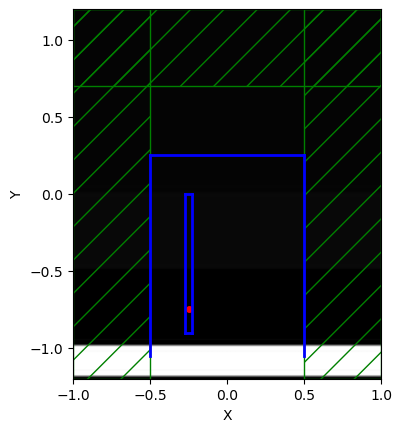

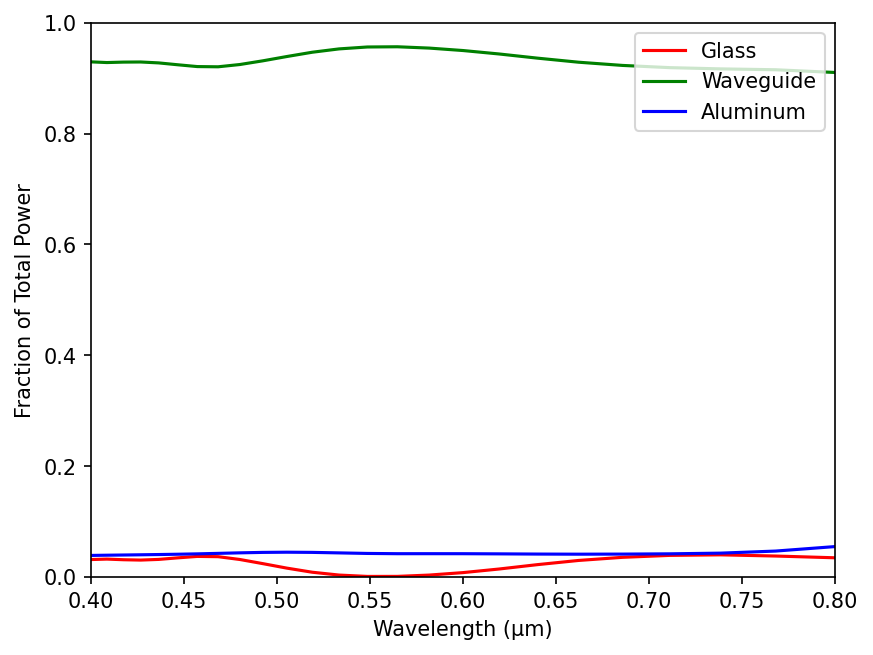

FloatProgress(value=0.0, description='0% done ')

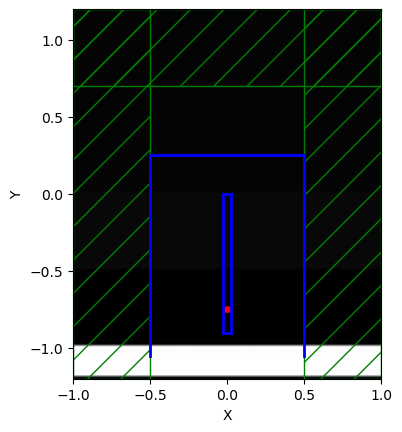

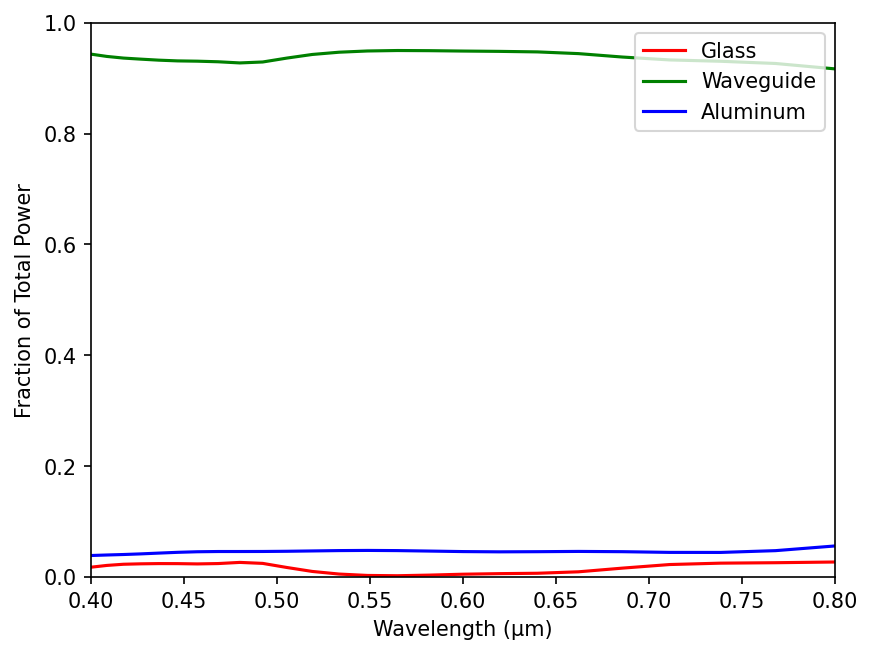

FloatProgress(value=0.0, description='0% done ')

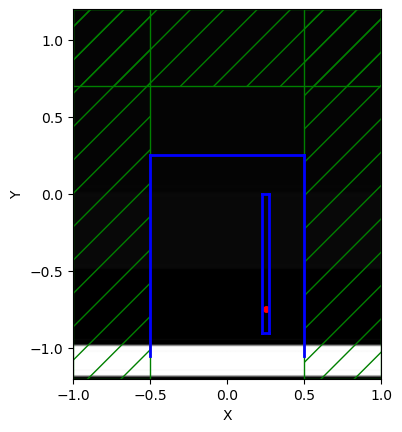

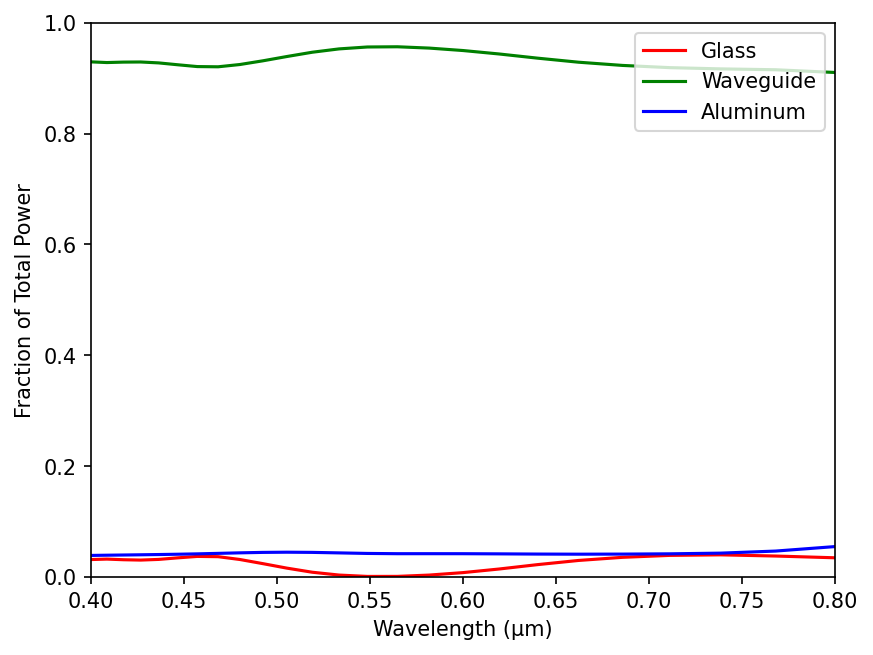

In [60]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo[i] = flux_srcbox_topo[i] - flux_srcbox_boto[i] + flux_srcbox_righto[i] - flux_srcbox_lefto[i]
    flux_total_glasso[i] = flux_glasso[i]
    flux_waveguideo[i] = flux_wvgbox_righto[i] - flux_wvgbox_lefto[i]

    wl = []
    gl = []
    wg = []
    al = []
    for d in range(nfreq):
        wl = np.append(wl, 1 / (flux_freqs[d]))
        gl = np.append(gl, flux_total_glasso[i][d] / flux_total_srcboxo[i][d])
        wg = np.append(wg, flux_waveguideo[i][d] / flux_total_srcboxo[i][d])
        al = 1 - gl - wg


    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, gl, "r", label="Glass")
        plt.plot(wl, wg, "g", label="Waveguide")
        plt.plot(wl, al, "b", label="Aluminum")

        
        plt.axis([0.40, 0.80, 0, 1])
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Fraction of Total Power")
        plt.legend(loc="upper right")
        plt.show()
        plt.cla()   # clear the current axes
        plt.clf()   # clear the current figure
        plt.close() # closes the current figure

In [61]:
flux_srcbox_top_s =[0]*src_num
flux_srcbox_bot_s =[0]*src_num
flux_srcbox_left_s =[0]*src_num
flux_srcbox_right_s =[0]*src_num

flux_glass_s =[0]*src_num
flux_wvgbox_right_s =[0]*src_num
flux_wvgbox_left_s =[0]*src_num

flux_total_srcbox_s =[0]*src_num
flux_total_glass_s =[0]*src_num
flux_waveguide_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

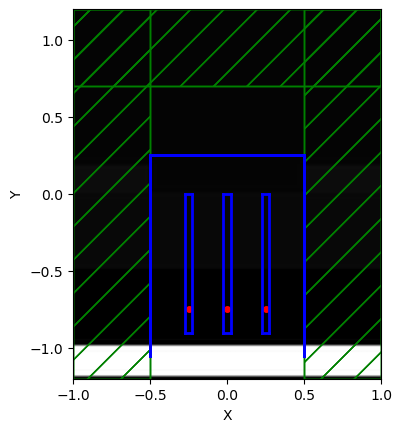

In [62]:
for i in range(src_num):
    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopt[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopt[i].sim.plot2D()

    ppopt[i].sim.run(until=100.0)

    flux_srcbox_top_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_bot_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_right_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_left_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glass_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_right_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_left_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcbox_s[i] = flux_srcbox_top_s[i] - flux_srcbox_bot_s[i] + flux_srcbox_right_s[i] - flux_srcbox_left_s[i]
    flux_total_glass_s[i] = flux_glass_s[i]
    flux_waveguide_s[i] = flux_wvgbox_right_s[i] - flux_wvgbox_left_s[i]



In [63]:
flux_srcbox_topo_s =[0]*src_num
flux_srcbox_boto_s =[0]*src_num
flux_srcbox_lefto_s =[0]*src_num
flux_srcbox_righto_s =[0]*src_num

flux_glasso_s =[0]*src_num
flux_wvgbox_righto_s =[0]*src_num
flux_wvgbox_lefto_s =[0]*src_num

flux_total_srcboxo_s =[0]*src_num
flux_total_glasso_s =[0]*src_num
flux_waveguideo_s =[0]*src_num

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

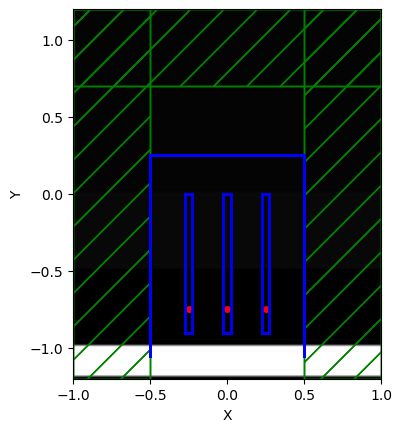

In [64]:
for i in range(src_num):
    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometryo,
                        sources=[sources[i]],
                        extra_materials=[ALU],)
    
    srcbox_width = 0.05
    srcbox_top = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_bot = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(x=-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
    srcbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
    srcbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width-design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

    fluxbox_dpad = 0.05

    glass_flux = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
    wvgbox_right = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
    wvgbox_left = ppopto[i].sim.add_flux(fcen, 0, 1, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))

    ppopto[i].sim.plot2D()

    ppopto[i].sim.run(until=100.0)

    flux_srcbox_topo_s[i] = np.asarray(mp.get_fluxes(srcbox_top))
    flux_srcbox_boto_s[i] = np.asarray(mp.get_fluxes(srcbox_bot))
    flux_srcbox_righto_s[i] = np.asarray(mp.get_fluxes(srcbox_right))
    flux_srcbox_lefto_s[i] = np.asarray(mp.get_fluxes(srcbox_left))

    flux_glasso_s[i] = np.asarray(mp.get_fluxes(glass_flux))
    flux_wvgbox_righto_s[i] = np.asarray(mp.get_fluxes(wvgbox_right))
    flux_wvgbox_lefto_s[i] = np.asarray(mp.get_fluxes(wvgbox_left))

    flux_freqs = mp.get_flux_freqs(glass_flux)

    flux_total_srcboxo_s[i] = flux_srcbox_topo_s[i] - flux_srcbox_boto_s[i] + flux_srcbox_righto_s[i] - flux_srcbox_lefto_s[i]
    flux_total_glasso_s[i] = flux_glasso_s[i]
    flux_waveguideo_s[i] = flux_wvgbox_righto_s[i] - flux_wvgbox_lefto_s[i]


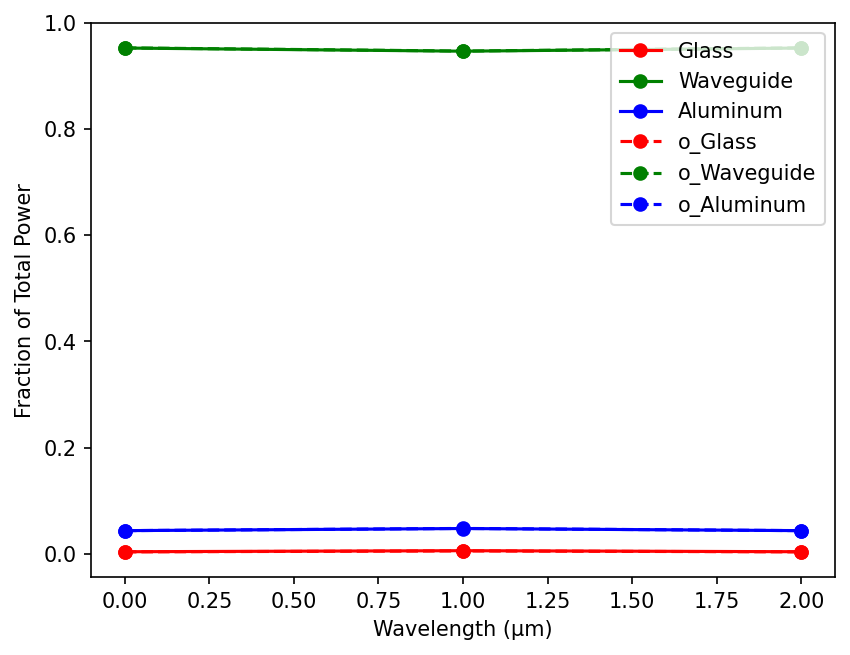

In [65]:
wl = []
gl = []
wg = []
al = []
o_gl = []
o_wg = []
o_al = []
for d in range(src_num):
    wl = np.append(wl, d)
    gl = np.append(gl, flux_total_glass_s[d] / flux_total_srcbox_s[d])
    wg = np.append(wg, flux_waveguide_s[d] / flux_total_srcbox_s[d])
    al = 1 - gl - wg
    o_gl = np.append(o_gl, flux_total_glasso_s[d] / flux_total_srcboxo_s[d])
    o_wg = np.append(o_wg, flux_waveguideo_s[d] / flux_total_srcboxo_s[d])
    o_al = 1 - o_gl - o_wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r-o", label="Glass")
    plt.plot(wl, wg, "g-o", label="Waveguide")
    plt.plot(wl, al, "b-o", label="Aluminum")
    plt.plot(wl, o_gl, "r--o", label="o_Glass")
    plt.plot(wl, o_wg, "g--o", label="o_Waveguide")
    plt.plot(wl, o_al, "b--o", label="o_Aluminum")

    
    # plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [66]:
print(flux_total_glass_s)

[array([0.00089783]), array([0.00140945]), array([0.00089783])]


In [67]:
print(flux_total_glasso_s)

[array([0.00083207]), array([0.00131077]), array([0.00083207])]
